# Qiskit Fall Fest 2023

![QFF Logo](images/QFF-logo.png)

## Challenge 10: Quantum Error Correction

#### 이번 챌린지에서는 repetition code 를 이용한 quantum error correction을 다룰 것입니다. <br>

고전 오류 정정 부호 (Classical Error Correction Code)에 대한 지식이 있으면 이해가 용이합니다. 
이 챌린지는 IBM quantum spring challenge 2023을 참고하여 만들어졌습니다. 
챌린지보다 자세한 내용은
[Qiskit Textbook](https://learn.qiskit.org/course/quantum-hardware/introduction-to-quantum-error-correction-via-the-repetition-code)을 참고하시기 바랍니다.
완주를 기원합니다!

In [1]:
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram


import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

## 고전 오류 정정 부호 (Classical Error Correction Code)
 우리가 통신을 할 때에는 항상 오류의 가능성이 존재합니다. 
아주 간단한 비트를 보내는 순간에도, 채널, 주파수, 신호의 크기, 삼각함수의 각도 등 많은 이유로 항상 에러가 발생할 확률이 있습니다.
1 bit의 데이터를 보낸다 하더라도 에러 발생 확률로 비트가 뒤집힐 수 있기 때문에, 수신자는 0을 1로, 1을 0으로 받게 될 수 있습니다.<br>  
 예를 들어, 비트가 뒤집힐 확률 (오류 발생 확률)이 10%라고 해봅시다. 
이것은 우리가 보내는 데이터의 각 비트에 대해 수신된 비트가 올바르지 않을 가능성이 1/10이라는 뜻입니다.
즉, 0000000000을 보냈을 때 0001000000가 수신될 수 있다는 의미입니다.

## Repetition Code
가장 간단한 해결책 중 하나는 반복을 사용하는 것입니다. 예를 들어, 데이터 1을 3번 반복해 111로 인코딩하거나, 0을 3번 반복해 000으로 인코딩하는 것이지요. 
이게 어떻게 해결책이 될 수 있을까요? 만약 000을 보냈는데 오류가 발생하여 001을 수신했을 수 있습니다. 과반수의 데이터로 판단한다면 이 경우 000을 수신한 것으로 추측하여 뒤집힌 하나의 비트를 정정할 것입니다.
그러나 만약 에러가 과반수 이상이면 어떻게 될까요? 수신한 메시지가 011이면 수신기는 이것을 111로 받아들일 것입니다. 진정한 오류가 생긴 것입니다!  
 반복을 사용하는 경우 에러를 줄일 수는 있지만 완벽하게 없애지는 못합니다. 몇번을 반복해야 에러율을 줄일 수 있는 것일까요? <br>  
 아래의 코드를 사용하여 에러가 어떻게 바뀌는지 확률을 확인해 봅시다. 

In [2]:
#3개의 비트 중 1개의 오류 확률은 0.1입니다
p1 = 0.10

#3개의 비트 중 2개 혹은 3개의 비트에 에러가 날 확률은 다음과 같습니다
p3 = 3 * p1 * p1 * (1 - p1) + p1 * p1 * p1

print("Percent chance the 000 message has one error: {}".format(p1 * 100))
print("Percent chance the 000 message has 2 or 3 errors: {:.4f}".format(p3 * 100))

Percent chance the 000 message has one error: 10.0
Percent chance the 000 message has 2 or 3 errors: 2.8000


반복을 사용하면 보정할 수 없는 메시지가 생길 확률이 2.8%로 줄어듭니다. 
이렇게 반복을 통해 1비트를 3비트로 늘리는 과정을 인코딩(encoding) 혹은 부호화라고 합니다. 
반대로 3비트를 다시 1비트로 되돌리는 것을 디코딩(decoding) 혹은 해독이라고 합니다. 

## 문제 1: Decoder 구현하기
큐비트 0,1,2를 사용하여 3 비트 상태를 큐비트 3의 1 비트로 만드는 디코더를 구현하세요. 
Basic gate를 이용하여 할 수 있습니다. Toffoli gate를 사용하면 쉽게 구현할 수 있습니다. 
규칙은 다음과 같습니다.  
* 000-> 0
* 001-> 0
* 010-> 0
* 100-> 0
* 111-> 1
* 110-> 1
* 101-> 1
* 011-> 1  

In [3]:
# 고전적인 간단한 디코더를 만들어 봅시다
def create_decoder(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # 하나의 비트가 첫 3개의 큐비트로 인코딩되고 4번째 큐비트에 디코딩되도록 합니다
    # 첫 3개 큐비트의 값은 변하지 않습니다

    qc = QuantumCircuit(qr, cr)
    q0, q1, q2, q3 = qr
    (c0,) = cr

############## Insert code here ##############
    qc.ccx(q0, q1, q3)
    qc.ccx(q1, q2, q3)
    qc.ccx(q0, q2, q3)
##############################################

    return qc

만든 디코더의 동작을 확인해봅시다. 오류 정정 회로가 어떻게 동작하는지 확인하기 위해 각기 다른 입력값에 대해 실행해봅시다. 

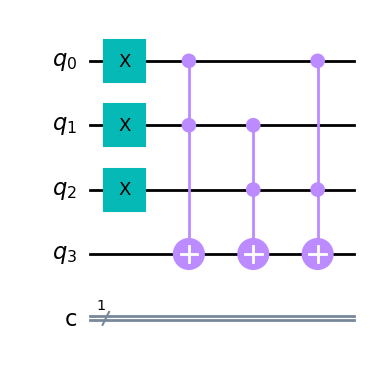

In [4]:
qr = QuantumRegister(4, name = 'q')
cr = ClassicalRegister(1, name = 'c')

q0, q1, q2, q3 = qr

# 인코딩해봅시다
encoder = QuantumCircuit(qr, cr)
encoder.x(q0)
encoder.x(q1)
encoder.x(q2)

decoder = create_decoder(qr, cr)
qc1 = encoder.compose(decoder)

qc1.draw("mpl")

In [6]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge10a

grade_challenge10a(create_decoder(qr, cr))


Congratulations 🎉! Your answer is correct.


## 양자 오류 정정 부호 (Quantum Error Correction Code)
고전적인 경우 오류 정정 코드를 구현하는 것은 비트를 여러 번 반복하여 얻을 수 있기 때문에 비교적 간단한 편입니다. 
더 복잡한 다른 코드들도 존재하지만 결국 대부분의 코드들은 정보를 반복함으로써 어떤 종류의 중복성을 갖는 것으로 구현합니다.  
양자의 경우, 다음 두 가지 구요 이유로 반복이 쉽지 않습니다.<br>  
1. 복제 불가 정리(no cloning theorem)로 인해 큐비트의 상태를 복제 할 수 없다.

2. 큐비트를 측정하면 상태가 붕괴되므로, 얽힌 큐비트들을 취급할때 주의해야 한다.  

그럼에도 불구하고 양자적 오류 정정을 할 수 있습니다. 핵심은 **보조 큐비트(Stabilizer Qubit)** 을 사용하는 것 입니다. 
Stabilizer qubit을 측정하면 오류가 어디서 일어났는지에 대한 정보를 얻을 수 있습니다. 

## 큐비트 에러
양자에는 두 종류의 에러가 발생할 수 있습니다. 
고전 비트와 같이 비트 에러가 발생할 수 있고, Phase 에러라고 하는 또 하나의 에러가 발생할 수 있습니다.  <br>
비트 에러(Bit - Flip Error)는 고전 비트와 같습니다. 0이 1로, 1이 0으로 반전되는 것입니다. 이를 앞서 배운 Pauli gate와 연관지어 생각하면, 0에 X gate를 씌워 1로 비트 에러를 만들 수 있겠죠. 이것은 추후 나올 에러 보정 방법의 원리입니다. 
X gate로 비트 반전 에러를 만들거나 보정할 수 있기 때문에 비트 반전 에러는 X error라고 불리기도 합니다. <br>  
Phase 에러는 고전 비트에는 없는 에러입니다. Phase 에러는 쉽게 생각하면 부호의 반전이 일어나는 것입니다. 예를 들어 $|0\rangle$ 상태에 Hadamard gate를 씌우면 $|+\rangle$ 상태가 됩니다. Phase error가 일어나면 $|+\rangle$상태가 $|-\rangle$ 상태로 반전될 수 있습니다. 
이러한 부호의 반전은 앞서 Z gate로 발생시킬 수 있음을 배웠습니다. 보정에도 똑같이 Z gate를 이용하여 부호를 반전시킵니다. 따라서 Phase 에러도 Z error라 불립니다. <br>
우선, 비트 반전 에러에 대한 반복 코드를 구현해봅시다. 

### 비트 반전(Bit - Flip) 반복 코드 구현

In [7]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(3, name = "encoding")
stabilizer = QuantumRegister(2, name = "stabilizer")

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(3, name = "results")

result_b0, result_b1, result_b2 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(2, name = "syndrome")

syndrome_b0, syndrome_b1 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

#### 큐비트 초기화
우선 양자 상태를 준비해봅시다. 일반적으로 양자 상태를 다음과 같은 형태로 준비합니다.  
$$|\Psi_0\rangle \rightarrow |\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$$  
아래 회로에서는 물리적 상태를 다음과 같이 준비합니다.  
$$|\Psi_1\rangle = |1\rangle$$  

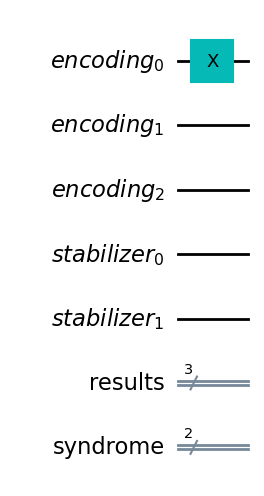

In [8]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])

initial_state.draw(output="mpl")

#### 큐비트 인코딩
고전적인 경우와 마찬가지로 초기 큐비트 상태의 반복을 사용하여 인코딩할 것입니다. 
구현하고자 하는 것은 인코딩 연산자 $U_{en}|\Psi_0\rangle$를 사용해 양자 상태 $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$를 인코딩하여 $ (\alpha |000\rangle + \beta |111\rangle)$로 만드는 것입니다.
이때, 처음 data qubit이 아닌 반복에 사용하는 큐비트를 **Ancilla qubit**이라고 부릅니다. 
인코딩된 상태는 얽힌 상태이며 한 큐비트를 측정하면 나머지 두 큐비트의 결과도 함께 결정됩니다. CX gate를 이용하여 얽힘 상태를 만들어봅시다. 

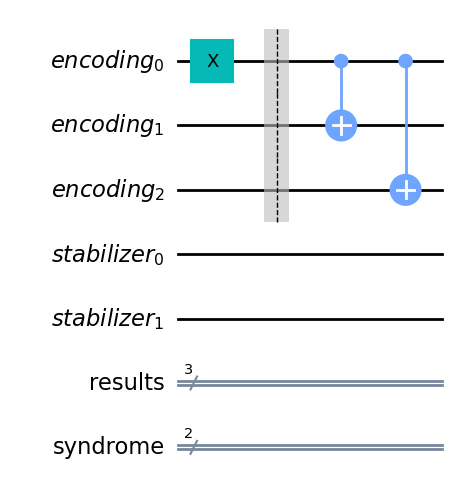

In [9]:
# Bit flip 코드를 이용하여 인코딩합니다
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


# 큐비트 인코딩 회로
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

# 지금까지의 모든 부분을 포함한 회로
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

#### 디코딩 회로 준비
원래 상태를 디코딩하기 위해 디코더를 구현해야 합니다. 
즉, 디코딩 연산자 $U_{de}|\Psi_0\rangle$는 $ (\alpha |000\rangle + \beta |111\rangle)$를   $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$에 매핑합니다.
정반대의 기능이기 때문에 인코더를 반전시켜 구현합니다. <br>
$U_{de} = U_{en}^\dagger$

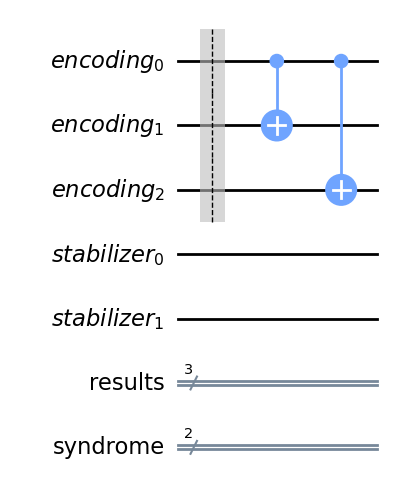

In [10]:
# 디코딩(인코딩의 reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

### Syndrome 계산
이제 단일 비트 반전 오류를 감지하도록 stabilizer qubit을 추가해 신드롬 (Syndrome)을 계산해봅시다. 
신드롬을 생성할 수 있는 경우의 수는 다음과 같습니다. <br>

00 -> 에러가 발생하지 않음

01 -> 에러가 qubit 0에서 발생함 (첫번째 큐비트)

10 -> 에러가 qubit 1에서 발생함 (두번째 큐비트)

11 -> 에러가 qubit 2에서 발생함 (세번째 큐비트)

회로는 다음과 같습니다. 

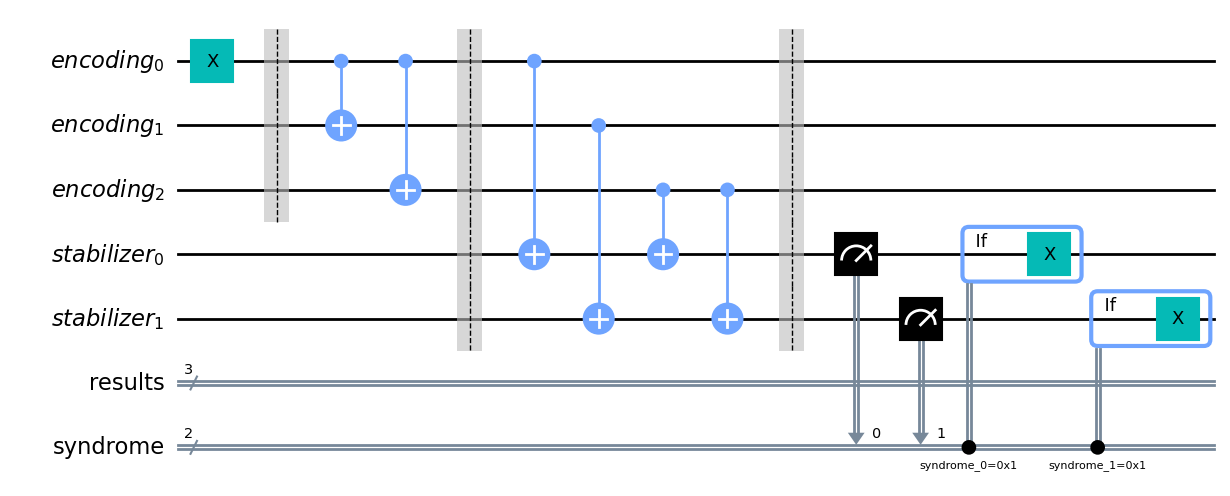

In [11]:
# 하나의 큐비트 반전을 검출할 수 있는 회로를 stabilizer qubit을 이용해 세워봅시다
# 2개의 stabilizer qubit이 사용됩니다
# 0 = 00 에러가 발생하지 않음
# 1 = 01 에러가 qubit 0에서 발생함 (첫번째 큐비트)
# 2 = 10 에러가 qubit 1에서 발생함 (두번째 큐비트)
# 3 = 11 에러가 qubit 2에서 발생함 (세번째 큐비트)
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # 인코딩 회로
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q2, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q1)

    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

Stabilizer를 측정해 에러가 난 곳을 확인할 수 있습니다. 

## 오류 정정
이제 Stabilizer qubit을 이용하여 오류 신드롬을 얻을 수 있게 되었습니다. 이제 오류를 정정해봅시다. 
고전적인 경우와 마찬가지로 3개의 큐비트로 이루어진 repetition code는 최대 1개의 오류만 정정할 수 있습니다. 
더 많은 오류를 정정하려면 5개 이상의 인코딩 큐비트가 필요합니다.  <br>
신드롬을 측정했기 때문에 단일 오류의 경우 어떤 큐비트가 반전되었는지 정확히 알 수 있으므로 오류를 쉽게 정정할 수 있습니다. 

## 문제 2: Bit error 정정하기

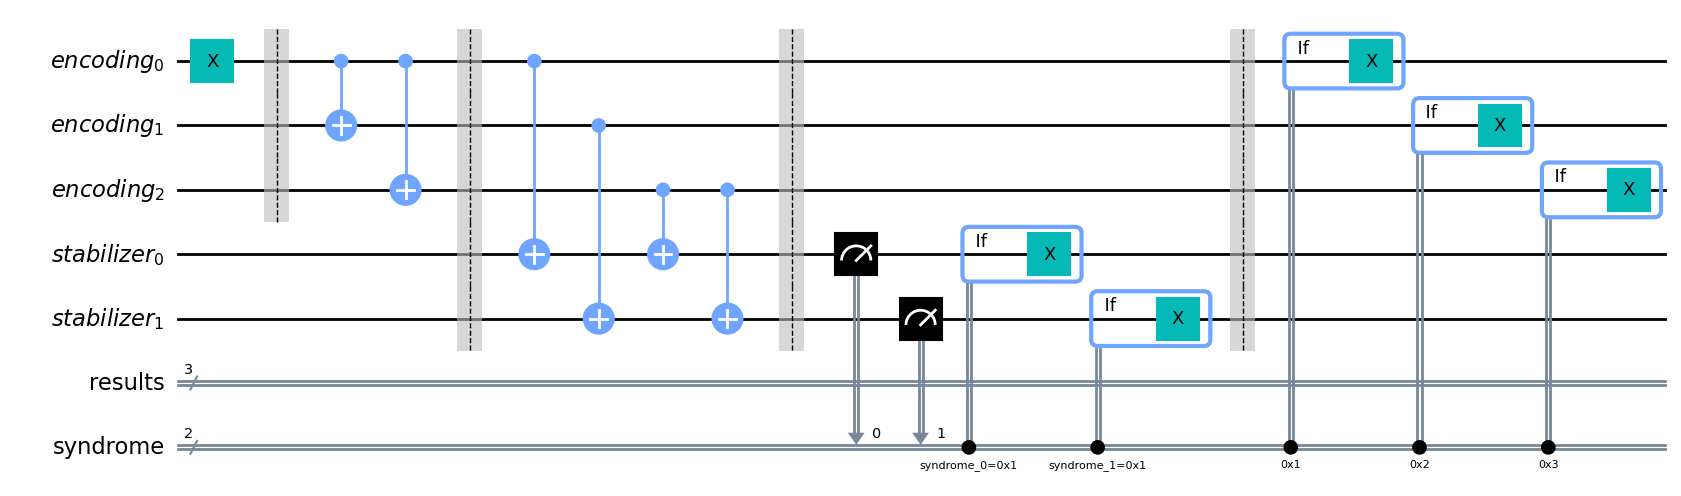

In [12]:
# 인코딩을 어떻게 했는지 생각하며 에러를 고쳐보세요!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    #########Insert your code here#############
    for i in range(0, encoding.size):
        with qc.if_test((syndrome, i + 1)):
            qc.x(encoding[i])
    ############################################

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")

만든 회로를 측정해봅시다

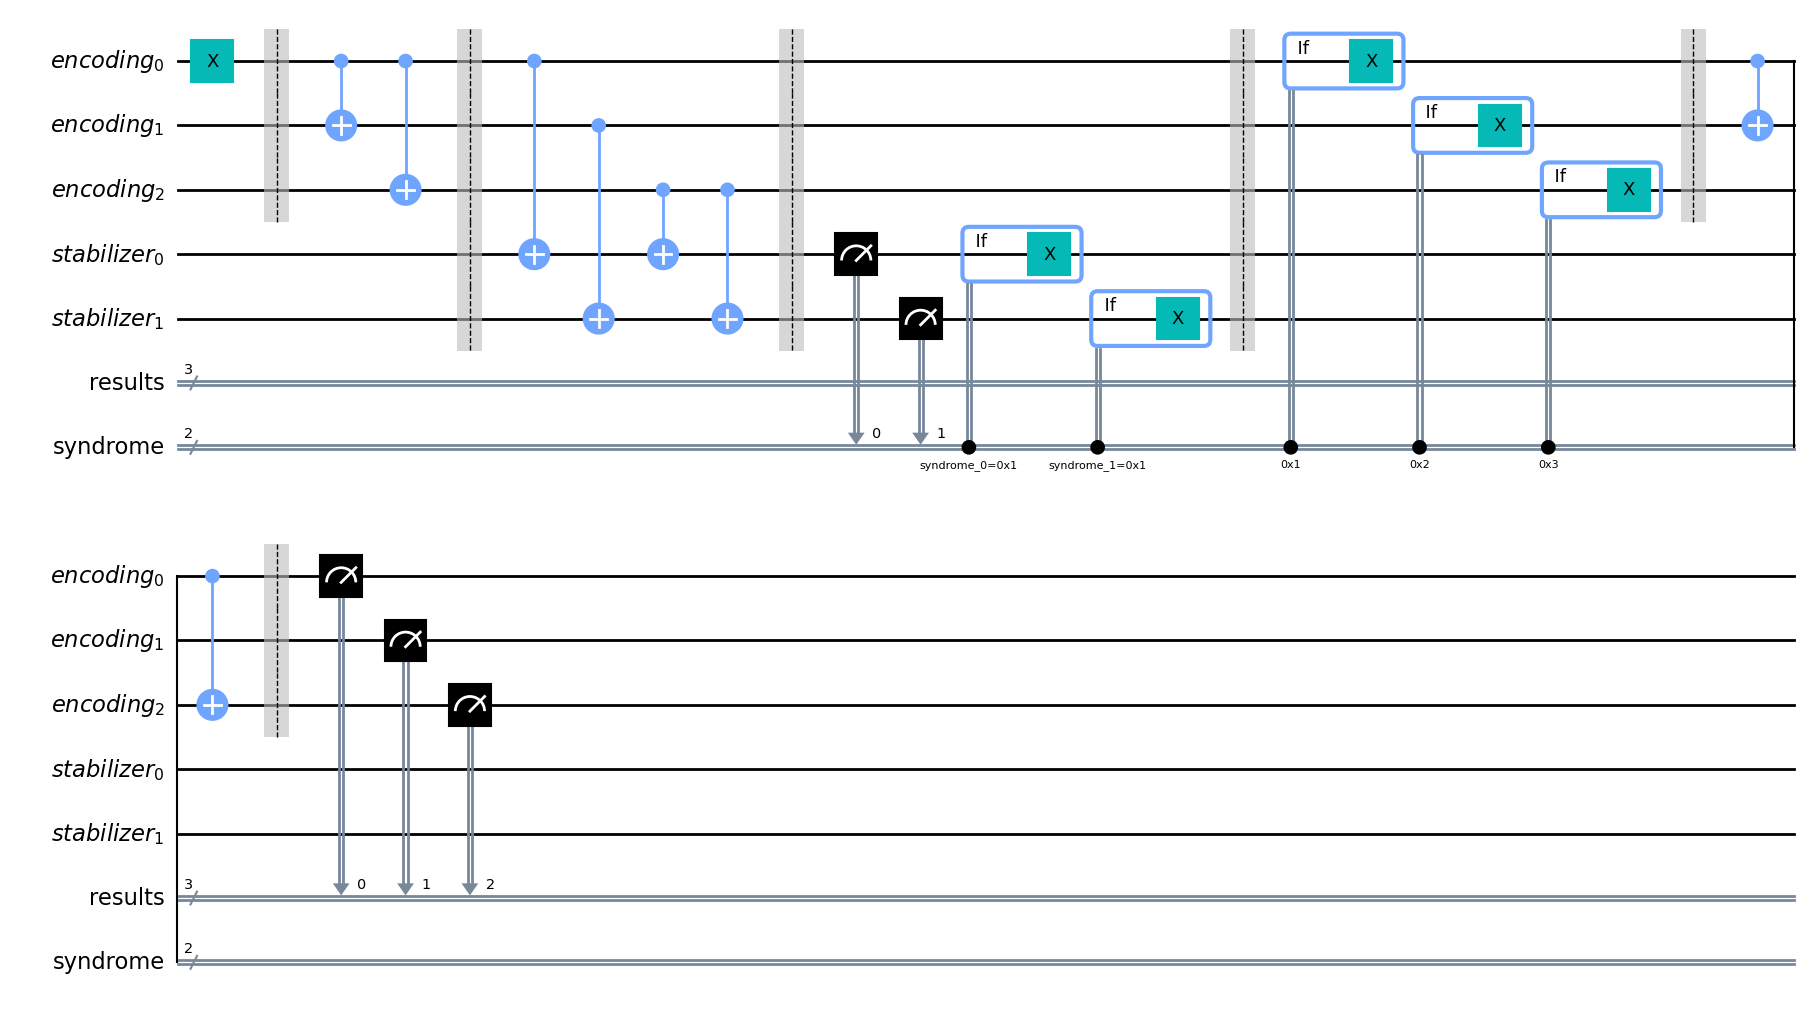

In [13]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

In [15]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge10b

grade_challenge10b(complete_circuit)


Congratulations 🎉! Your answer is correct.


#### 테스트 1. 오류 없는  버전
오류가 없을 때 측정하면 다음과 같습니다. 딱 하나의 경우만 측정됩니다. 오류가 없다면 하나의 값이 측정되는 것은 너무나도 당연합니다!

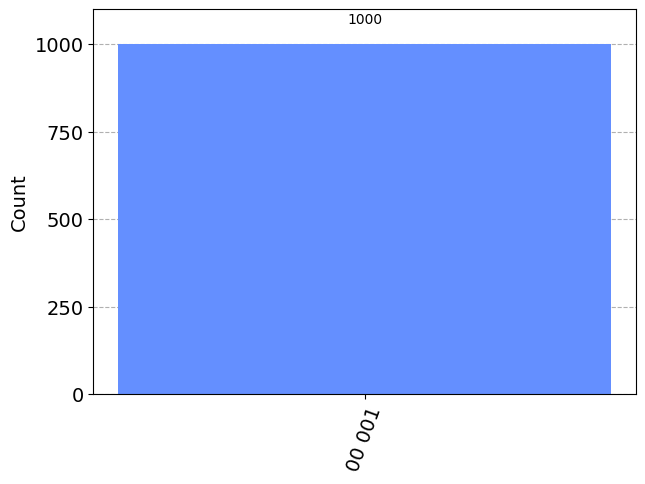

In [16]:
# We first choose a simulator as our backend without any noise
backend = Aer.get_backend("qasm_simulator")
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

#### 테스트 2. 노이즈 추가
노이즈를 추가하고 시뮬레이션하면 여러 경우가 측정됩니다. 노이즈 때문에 특정값으로 측정되지 않는 것입니다. 

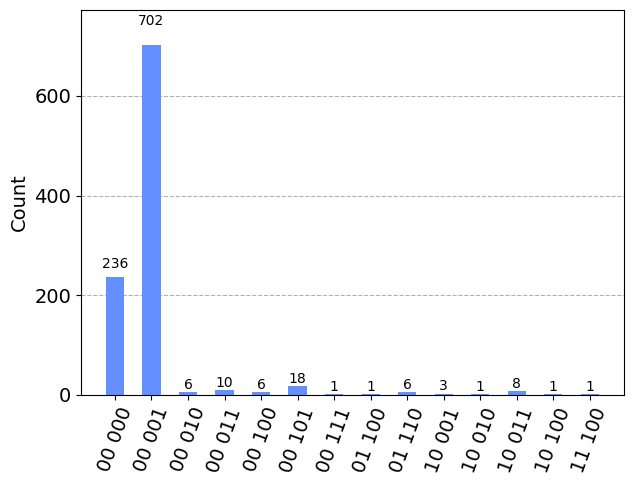

In [17]:
# We choose a simulator for Manila a 5 qubit device, includes errors
backend = FakeManilaV2()
# We run the simulation and get the counts
counts = backend.run(complete_circuit, shots=1000).result().get_counts()
# We plot a histogram to see the possible outcomes and corresponding probabilities
plot_histogram(counts)

다음은 에러 보정 없이 회로가 얼마나 잘 동작하는지 확인해봅시다. 

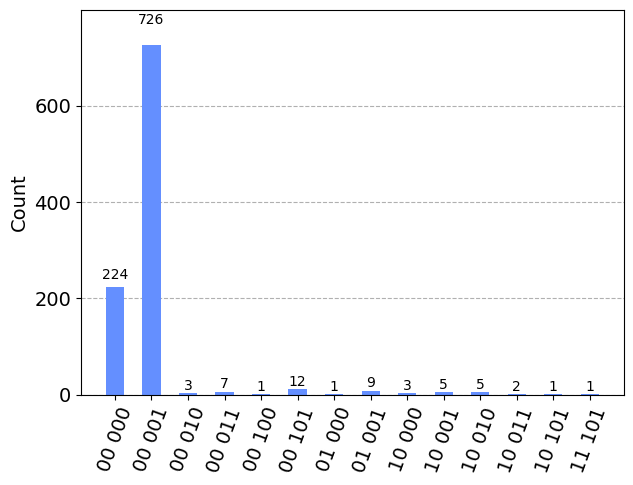

In [18]:
qc3 = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose a again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc3, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

다음은 노이즈를 발생시키는 회로를 만들고 오류를 넣어서 테스트해봅시다. 

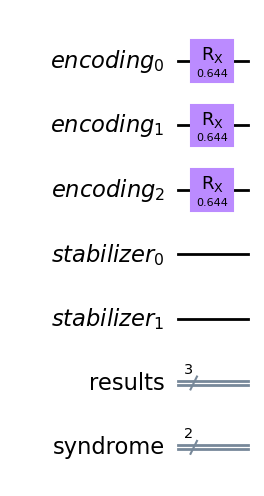

In [19]:
# Add some errors as defined above (only add errors to the encoding qubits)
def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome

    alpha = 2*math.asin(math.sqrt(error_percentage/100))
    qc.rx(alpha, encoding_q0)
    qc.rx(alpha, encoding_q1)
    qc.rx(alpha, encoding_q2)
    
    return qc


# Constructing a circuit with 10% error rate (for each of the encoding qubit)
noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, 10)
noise_circuit.draw(output="mpl")

먼저 오류 정정 코드가 없는 경우 어떠한 측정 결과가 나오는지 보겠습니다. 측정 결과 중에서 뒤에 3bits가 $001$로 측정된 경우가 오류가 없는 경우 입니다. 각각의 qubit가 10% 확률로 오류가 발생하니 3개의 qubit 모두에 오류가 발생할 확률은 $1-0.9^3 = 0.271$ 입니다. 거기에 아래의 코드셀에서는 backend를 자체적으로 에러가 발생하는 `FakeManila`로 설정하였기에, 오류율은 증가할 것입니다.

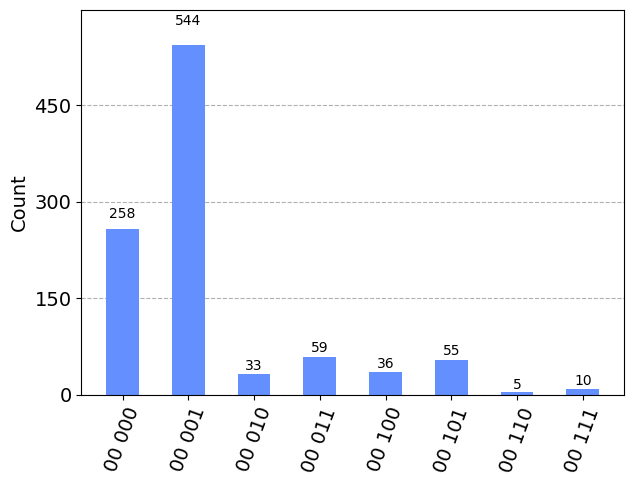

In [20]:
qc4 = (
    initial_state
    .compose(noise_circuit)
)
qc4.measure(encoding, results)


# We choose again FakeManila
backend = FakeManilaV2()

# let the simulation run
counts = backend.run(qc4, shots=1000).result().get_counts()
# and plot our results
plot_histogram(counts)

이번엔 오류정정 코드가 있는 경우를 보겠습니다! 뒤의 세개의 bit가 $001$로 측정된 경우가 오류가 발생하지 않은 경우입니다!

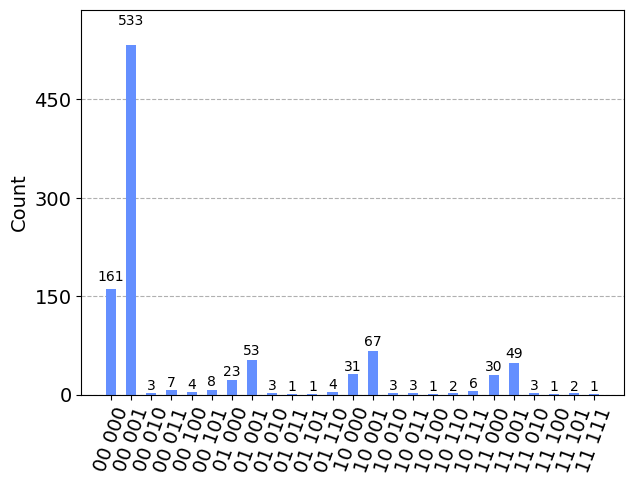

dict_keys(['01 001', '11 000', '00 001', '01 000', '10 001', '11 001', '00 000', '01 110', '00 101', '00 011', '10 010', '11 100', '10 000', '10 111', '01 010', '00 100', '11 111', '00 010', '10 100', '01 101', '10 011', '01 011', '11 010', '11 101', '10 110'])


In [21]:
qc4 = (
    initial_state.compose(encoding_circuit)
    .compose(noise_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)


# We choose again FakeManila
backend = FakeManilaV2()
# let the simulation run
counts = backend.run(qc4, shots=1000).result().get_counts()
# and plot our results
display(plot_histogram(counts))
print(counts.keys())

### 위상 반전(Phase- Flip) 반복 코드 구현
이제 Phase error를 발생시키고 보정해봅시다. Phase Error는 Hadamard gate가 적용된 상태에서 발생합니다.
repetition code는 다음과 같습니다. 
$$|0\rangle \rightarrow |+++\rangle$$
$$|1\rangle \rightarrow |---\rangle$$

In [47]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(3, name = "encoding")
stabilizer = QuantumRegister(2, name = "stabilizer")

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(3, name = "results")

result_b0, result_b1, result_b2 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(2)

syndrome_b0, syndrome_b1 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

에러는 다음과 같이 넣습니다

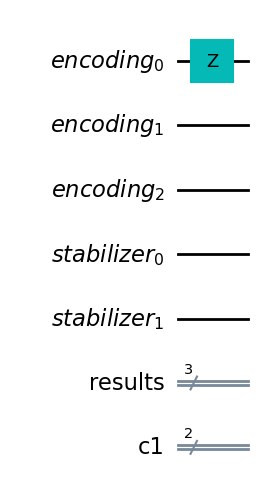

In [48]:
initial_state = initialize_circuit()

initial_state.z(encoding[0])

initial_state.draw(output="mpl")

Phase flip 코드를 이용해 인코딩합니다. bit repetition code와 비슷하지만 모든 큐비트에 H gate를 추가했습니다. 

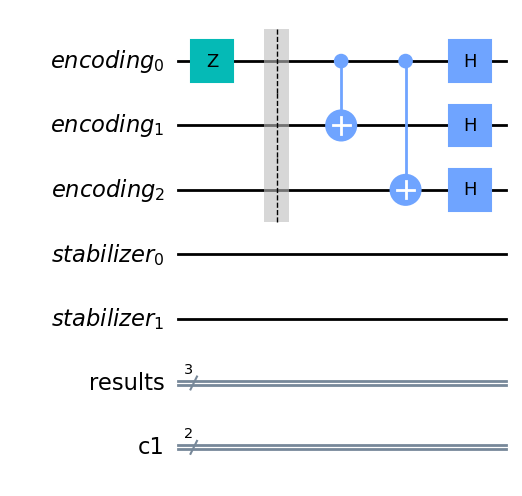

In [49]:
# Phase flip code를 이용한 인코딩
def encode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    qc.h(encoding[0])
    qc.h(encoding[1])
    qc.h(encoding[2])
    return qc


# 큐비트 인코딩 회로
encoding_circuit = encode_phase_flip(initialize_circuit(), state, ancillas)

# 지금까지 모든 부분을 포함한 회로
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

디코딩 회로는 다음과 같이 준비합니다. 
디코딩은 인코딩의 역과정이지만, Phase flip 디코딩 회로에서는 마지막에 Toffoli gate를 추가해야합니다. 
Hadamard gate가 얽힘상태에 영향을 줄 수 있기 때문에 CCX로 다시 얽힘상태를 만들어줍니다. 

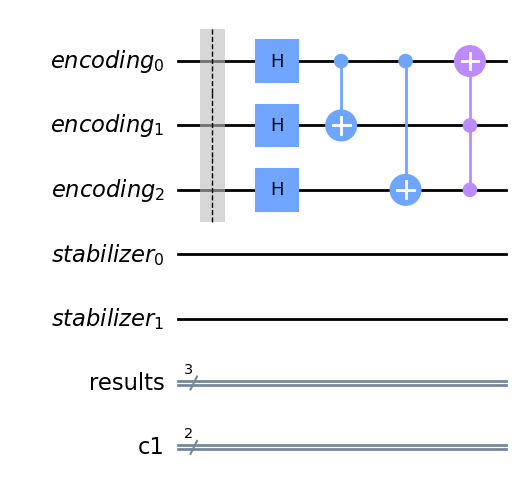

In [50]:
# 디코딩(인코딩의 역과정입니다)
def decode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    qc.h(encoding[0])
    qc.h(encoding[1])
    qc.h(encoding[2])
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    qc.ccx(encoding[2], encoding[1],encoding[0])
    return qc


decoding_circuit = decode_phase_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

앞선 Bit error correction과 마찬가지로 동일하게 Stabilizer qubit을 준비합니다. 

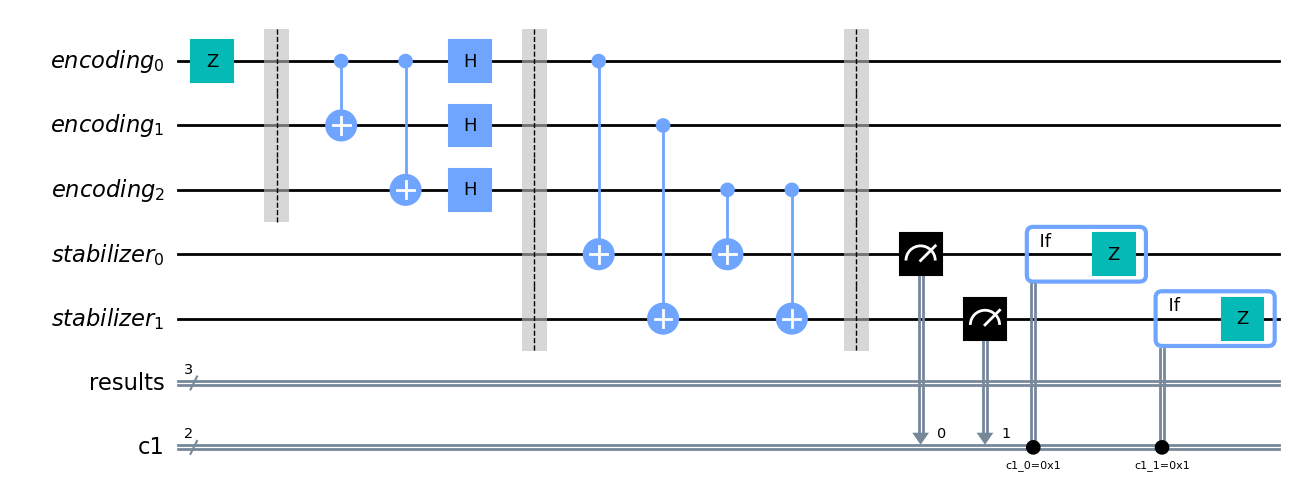

In [51]:
# 하나의 큐비트 반전을 검출할 수 있는 회로를 stabilizer qubit을 이용해 세워봅시다
# 2개의 stabilizer qubit이 사용됩니다
# 0 = 00 에러가 발생하지 않음
# 1 = 01 에러가 qubit 0에서 발생함 (첫번째 큐비트)
# 2 = 10 에러가 qubit 1에서 발생함 (두번째 큐비트)
# 3 = 11 에러가 qubit 2에서 발생함 (세번째 큐비트)
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # 인코딩 회로
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q2, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q1)

    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.z(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.z(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

## 문제 3: Phase error 정정하기
앞선 bit error correction과 동일한 방법으로 phase error을 correct 해보세요.

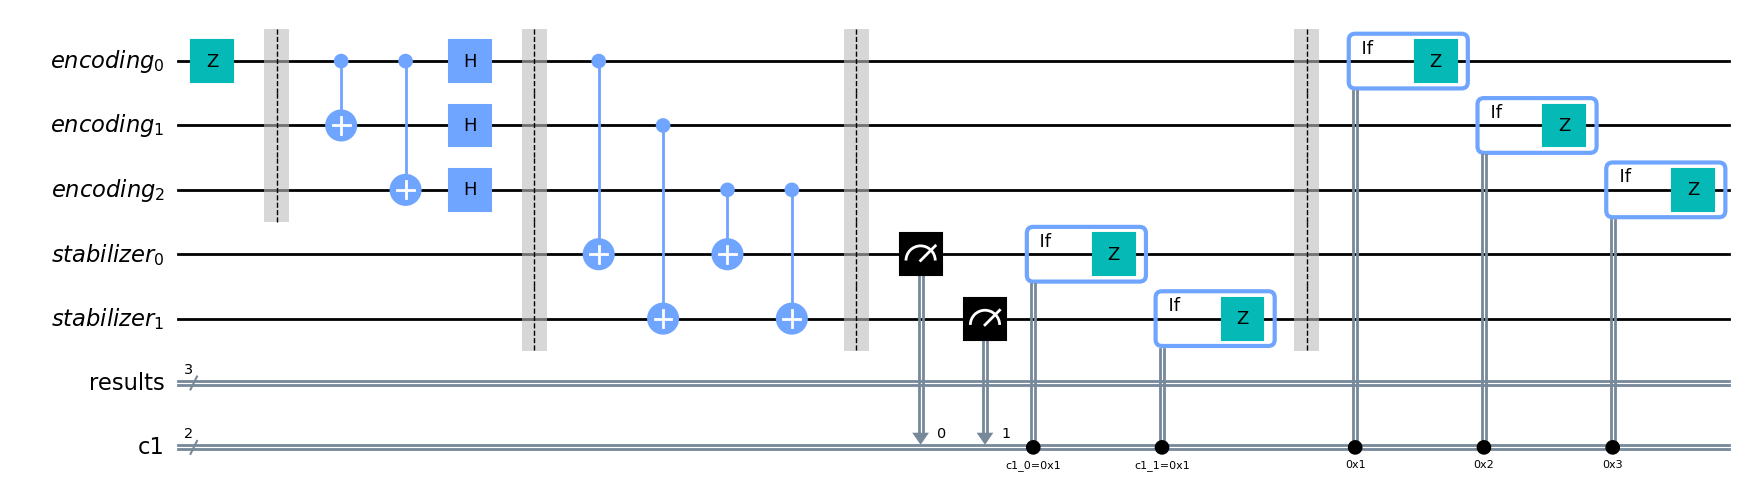

In [52]:
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    #########Insert your code here#############
    for i in range(0, encoding.size):
        with qc.if_test((syndrome, i + 1)):
            qc.z(encoding[i])
    ############################################

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")

인코딩 큐비트를 측정해 정정이 잘 되는지 확인해봅니다.

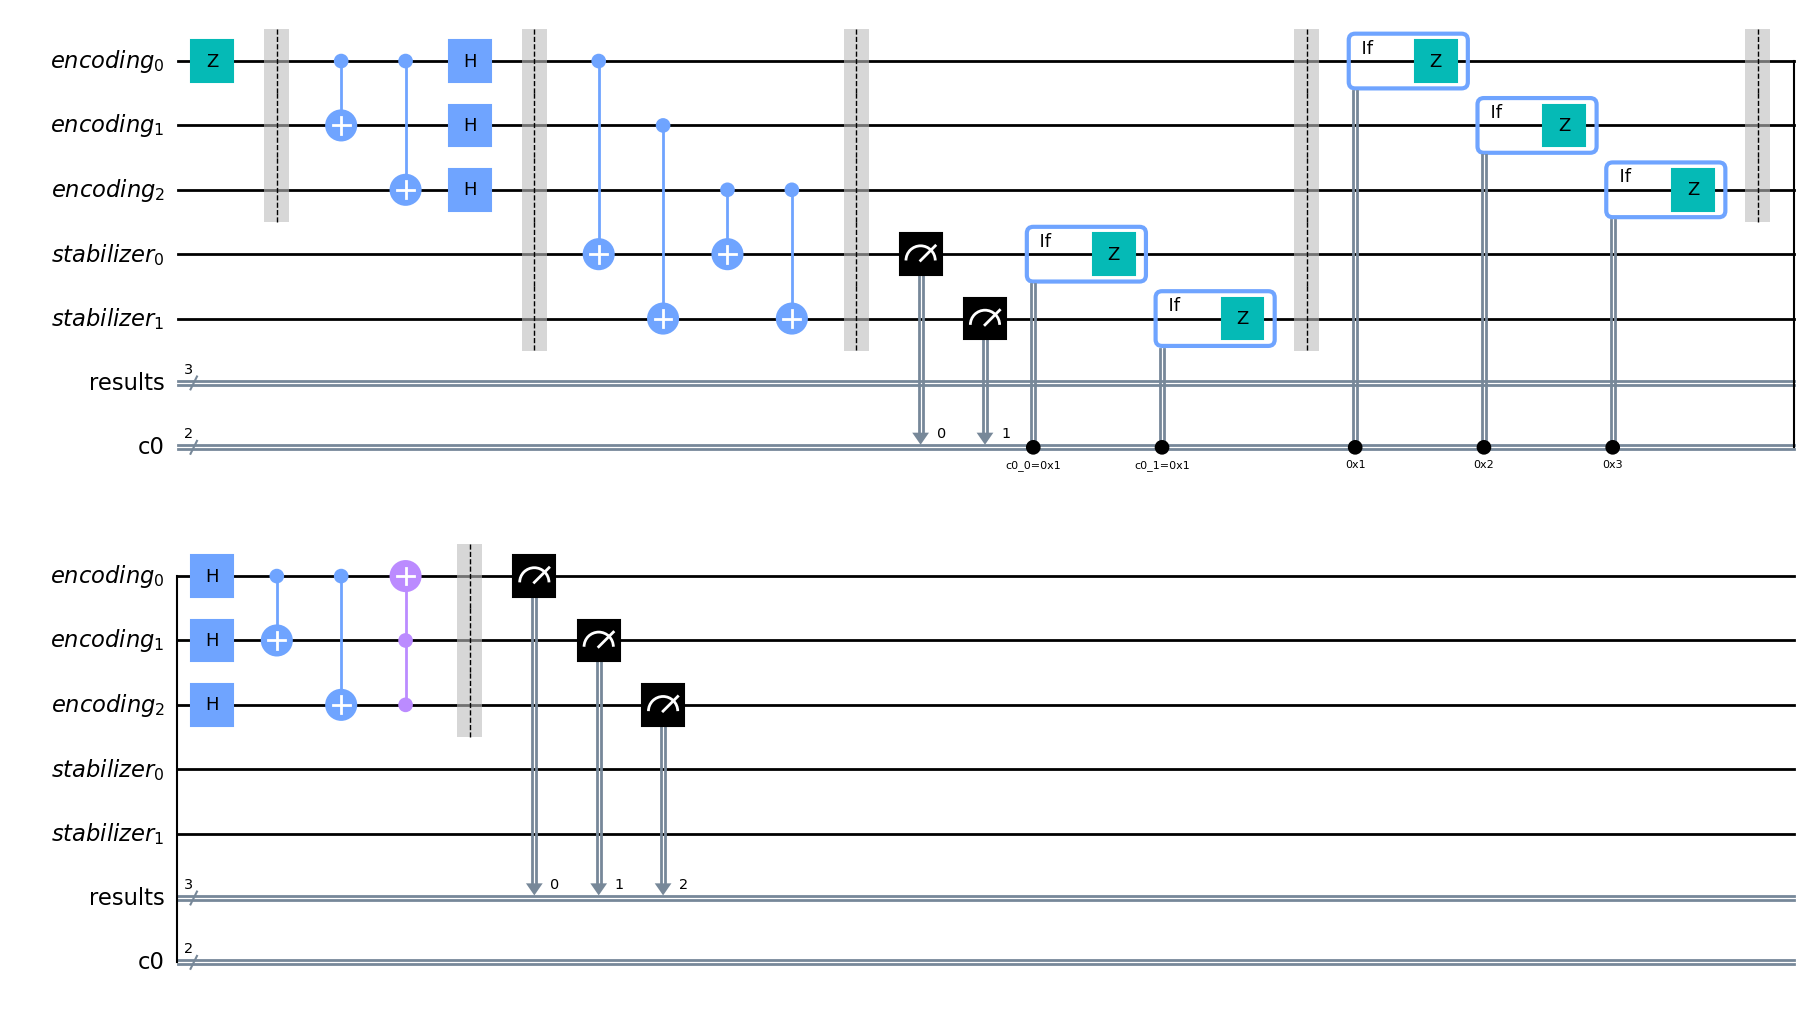

In [34]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

In [54]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge10c

grade_challenge10c(complete_circuit)


Oops 😕! Your answer is incorrect


In [36]:
# Phase error는 +가 -로, -가 +로 반전되는 것입니다. Qiskit에서는 Phase error을 측정할 수는 없어 테스트 결과가 의미가 없습니다. 

### Bit flip과 Phase flip을 모두 정정하는 회로를 짜봅시다.

여러분은 Bit flip과 Phase flip을 각각 인코딩, 디코딩하고 오류를 정정할 수 있게 되었습니다. 
이제 하나의 data qubit에 대해 Bit flip과 Phase flip을 모두 정정하는 회로를 생성해봅시다. 
앞선 인코딩과정에서 반복을 이용해 1개의 큐비트가 3개의 큐비트로 인코딩했습니다. 
여기서는 2가지의 에러를 검출해야하므로 3*3으로 9개의 큐비트를 이용합니다. 
즉, 1개의 data qubit과 8개의 repetition qubit을 이용하여 x 에러와 z 에러를 모두 고칠 수 있는 것입니다. <br>
힌트: x 인코딩을 먼저 시행하고, x 인코딩한 3개 큐비트를 각각 z 인코딩의 data qubit으로 인코딩합니다. 
이러한 repetition code를 **Shor code**라고 합니다. 

In [37]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(9, name = "encoding")

encoding_q0, encoding_q1, encoding_q2, encoding_q3, encoding_q4, encoding_q5, encoding_q6, encoding_q7, encoding_q8 = encoding

# Stabilizer
stabilizer = QuantumRegister(6, name = "stabilizer")

stabilizer_q0, stabilizer_q1, stabilizer_q2, stabilizer_q3, stabilizer_q4, stabilizer_q5 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(9, name = "results")

result_b0, result_b1, result_b2, result_b3, result_b4, result_b5, result_b6, result_b7, result_b8 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(6, name = "syndrome")

syndrome_b0, syndrome_b1, syndrome_b2, syndrome_b3, syndrome_b4, syndrome_b5 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]

# state를 인코딩하기 위해 사용된 ancillas
ancillas1 = encoding[3], encoding[6]
ancillas2 = encoding[1:3]
ancillas3 = encoding[4:6]
ancillas4 = encoding[7:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

X,Z 에러를 삽입합니다.

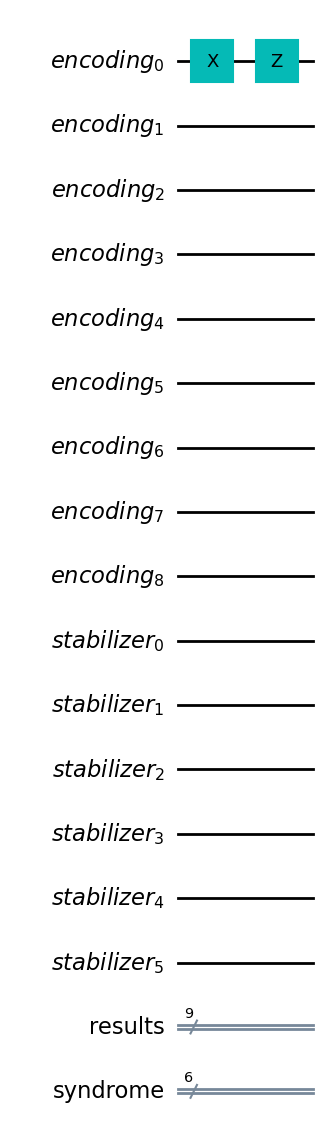

In [38]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])
initial_state.z(encoding[0])

initial_state.draw(output="mpl")

힌트: 인코딩회로는 다음과 같습니다. z 인코딩을 3 블럭으로 나눠한 것을 볼 수 있습니다.

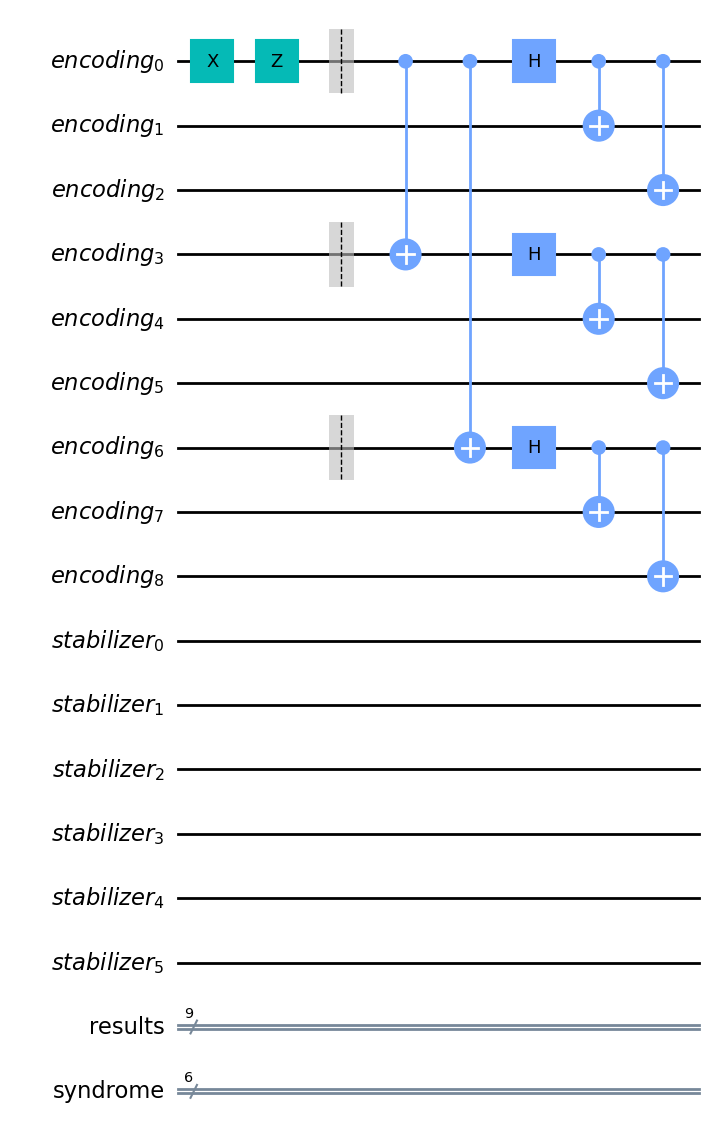

In [39]:
# Bit flip과 Phase flip을 인코딩합니다
def encode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas1)
    for ancilla in ancillas1:
        qc.cx(state, ancilla)
    qc.h(encoding[0])
    qc.h(encoding[3])
    qc.h(encoding[6])
    for ancilla in ancillas2:
        qc.cx(encoding[0], ancilla)
    for ancilla in ancillas3:
        qc.cx(encoding[3], ancilla)
    for ancilla in ancillas4:
        qc.cx(encoding[6], ancilla)
    return qc


# 인코딩 회로
encoding_circuit = encode_phase_flip(initialize_circuit(), state, ancillas)

# 지금까지 모든 부분을 포함한 회로
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

## 문제 4: X, Z 에러 디코딩 9 qubit 회로 만들기
제시한 인코딩회로를 참고하여 9 qubit 디코딩회로를 만들어보세요. <br>
힌트: Toffoli gate를 4번 이용하세요. 

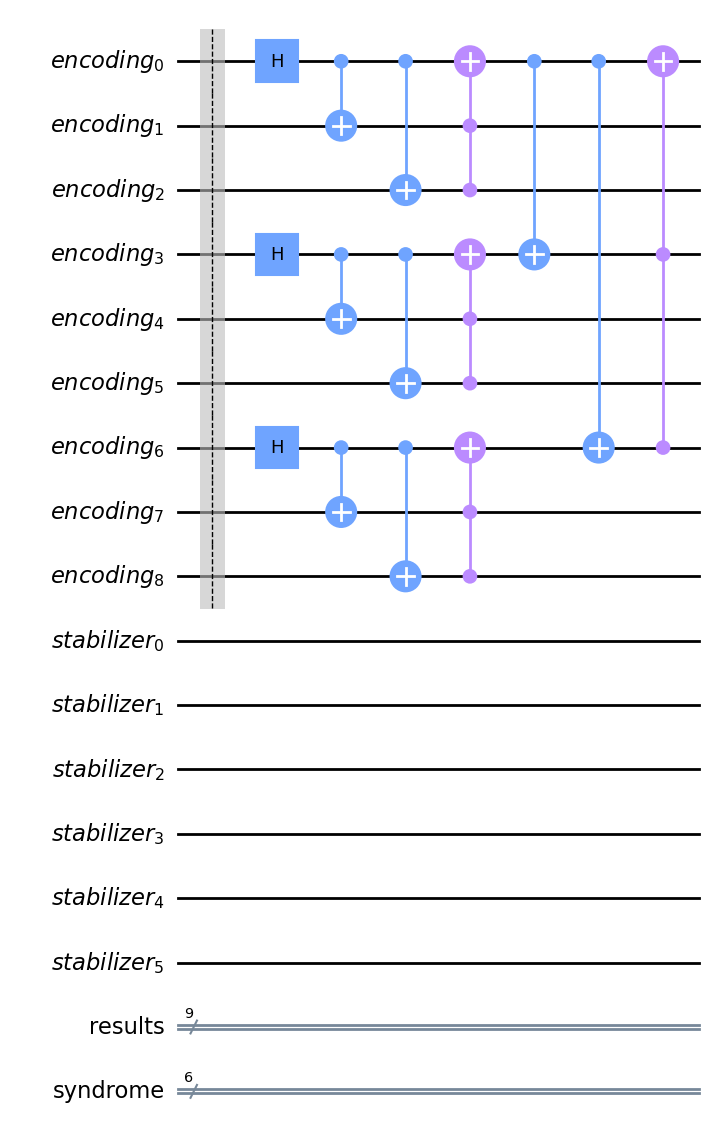

In [40]:
# 디코딩
def decode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas1, *ancillas2, *ancillas3,*ancillas4)
    
    #############Insert your code here#####################
    qc.h(encoding[0])
    qc.h(encoding[3])
    qc.h(encoding[6])
    for ancilla in ancillas2:
        qc.cx(encoding[0], ancilla)
    for ancilla in ancillas3:
        qc.cx(encoding[3], ancilla)
    for ancilla in ancillas4:
        qc.cx(encoding[6], ancilla)
    qc.ccx(encoding[2], encoding[1],encoding[0])
    qc.ccx(encoding[5], encoding[4],encoding[3])
    qc.ccx(encoding[8], encoding[7],encoding[6])
    for ancilla in ancillas1:
        qc.cx(encoding[0], ancilla)
    qc.ccx(encoding[6], encoding[3],encoding[0])
    ##########################################################
    
    return qc


decoding_circuit = decode_phase_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

In [43]:
# Grader Cell: Run this to submit your answer

from qff_ku_grader.challenges.qff_ku2023 import grade_challenge10d

grade_challenge10d(decoding_circuit)


Congratulations 🎉! Your answer is correct.


인코딩 후 Stabilizer qubit을 넣으면 다음과 같습니다. 

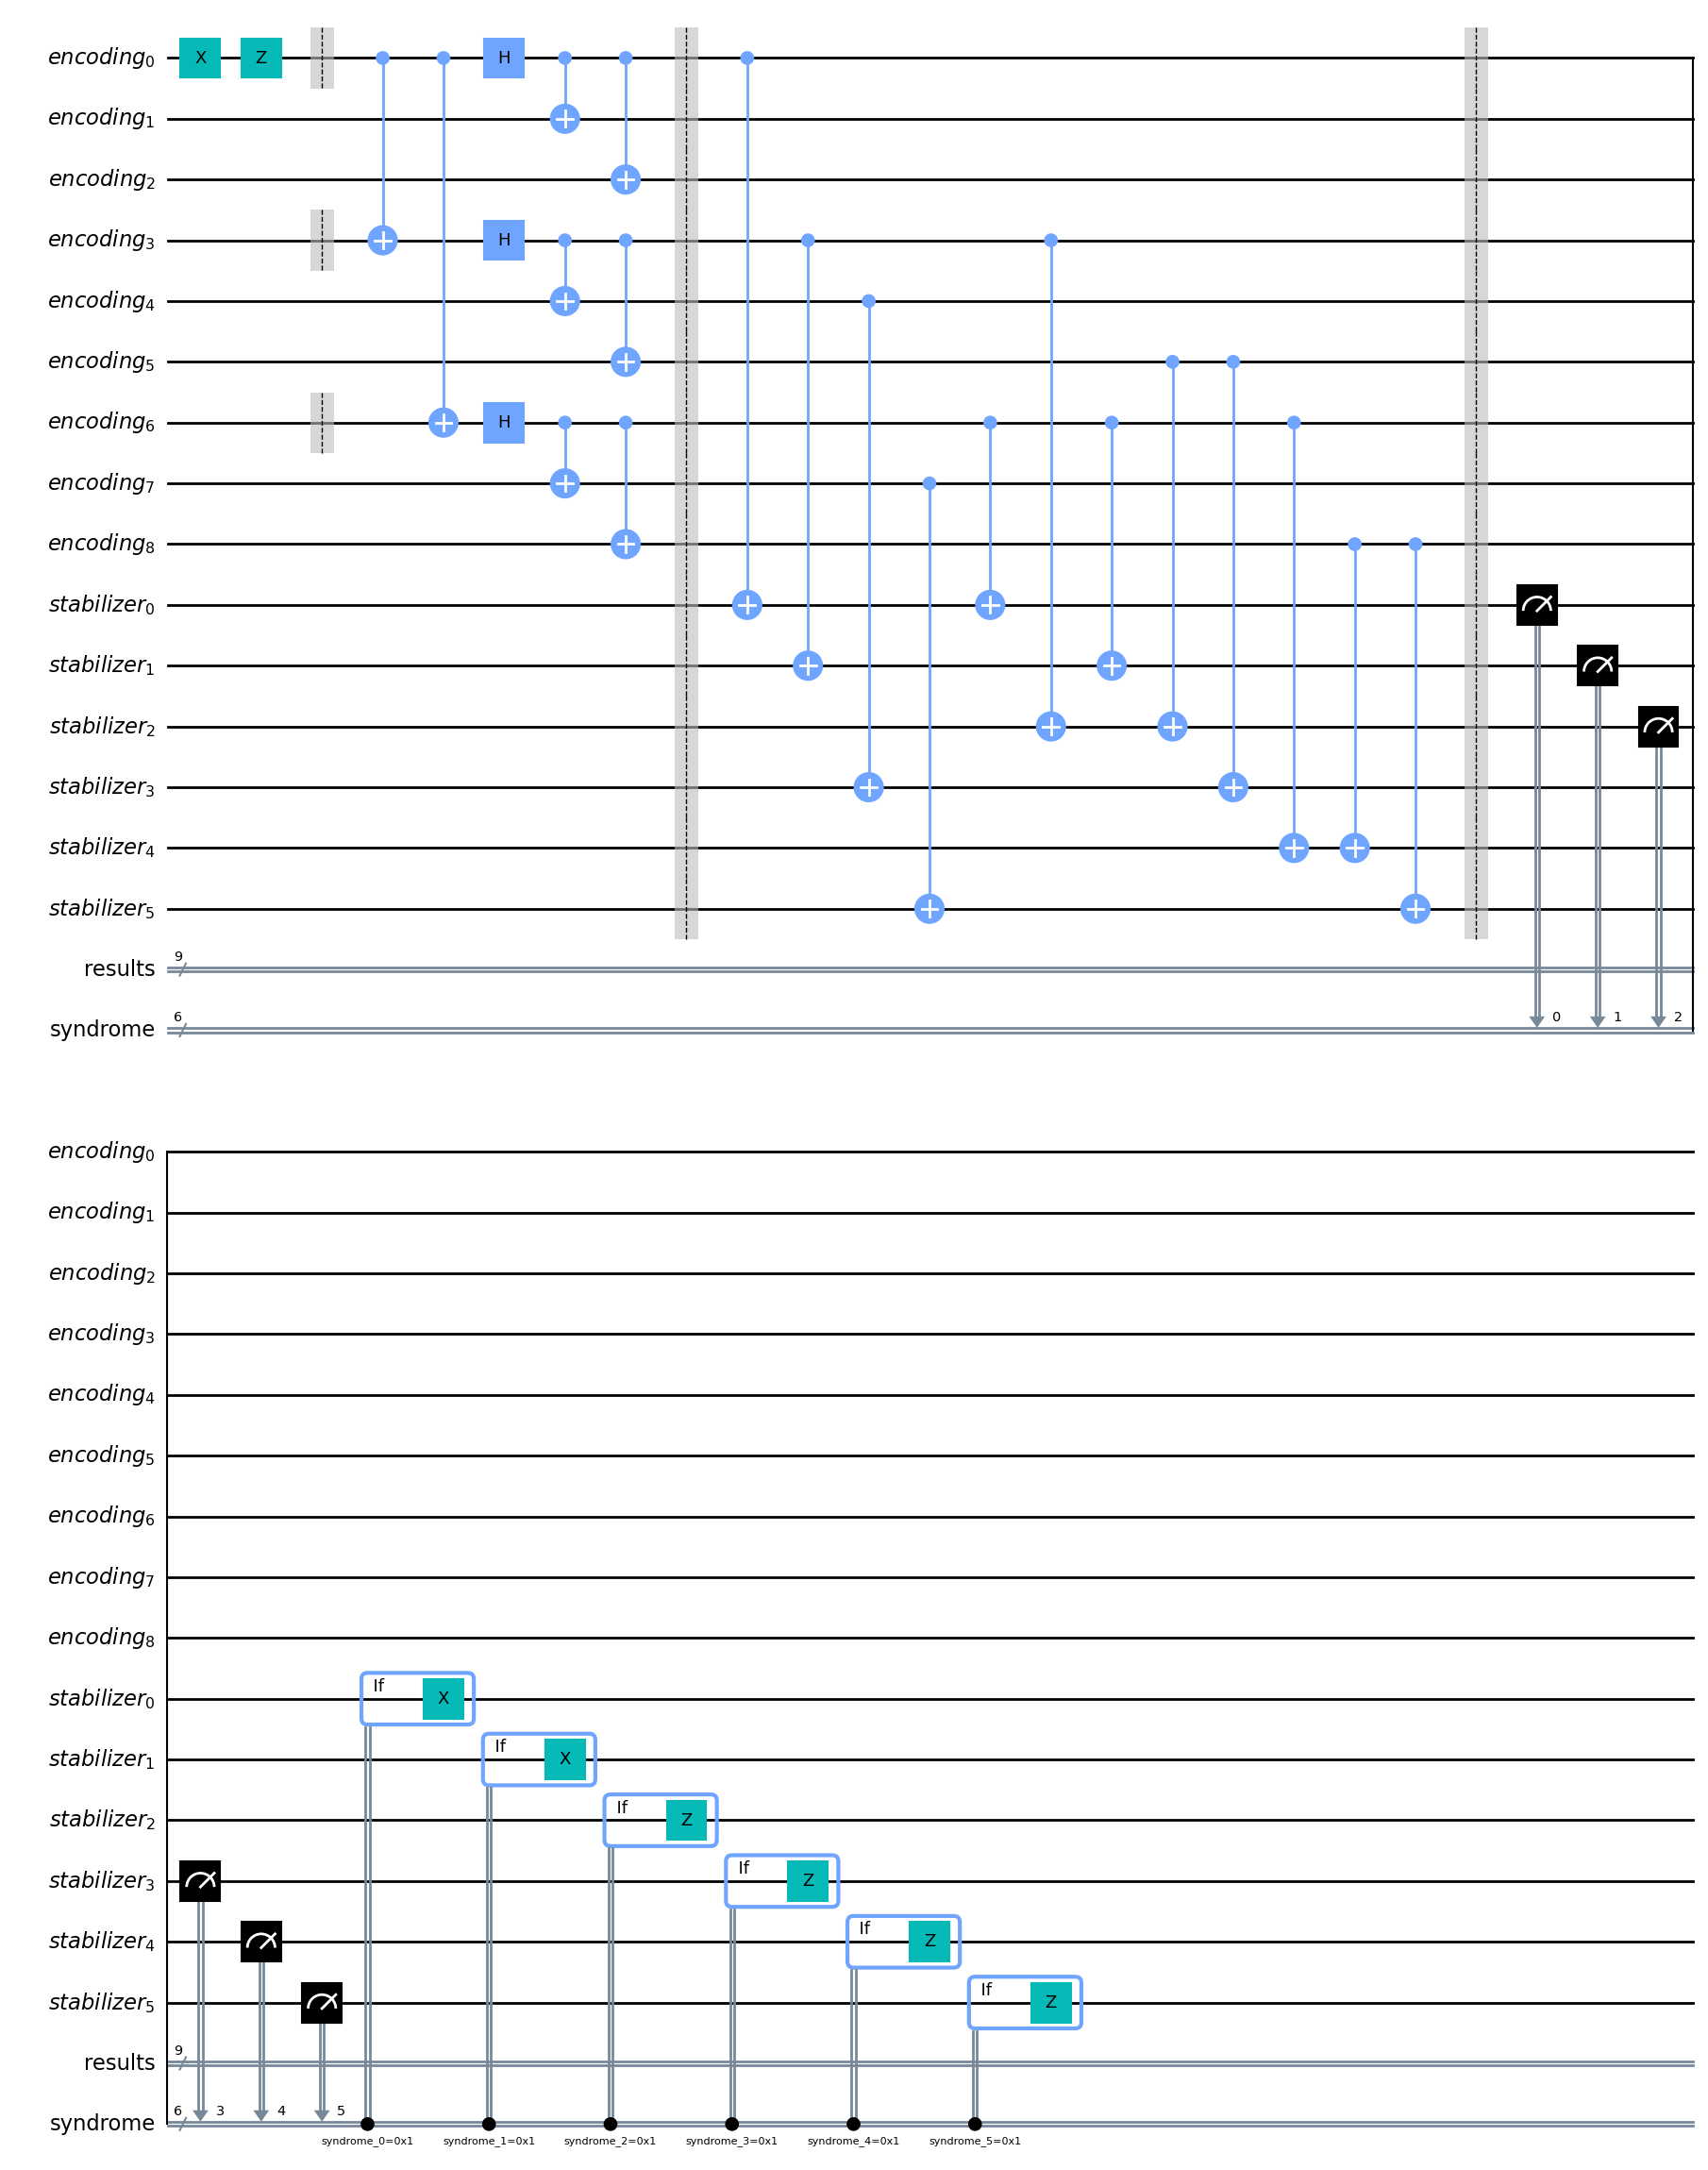

In [44]:
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2, encoding_q3, encoding_q4, encoding_q5, encoding_q6, encoding_q7, encoding_q8 = encoding
    stabilizer_q0, stabilizer_q1, stabilizer_q2, stabilizer_q3, stabilizer_q4, stabilizer_q5 = stabilizer

    # 인코딩 회로
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q6, stabilizer_q0)
    qc.cx(encoding_q3, stabilizer_q1)
    qc.cx(encoding_q6, stabilizer_q1)
    qc.cx(encoding_q3, stabilizer_q2)
    qc.cx(encoding_q5, stabilizer_q2)
    qc.cx(encoding_q4, stabilizer_q3)
    qc.cx(encoding_q5, stabilizer_q3)
    qc.cx(encoding_q6, stabilizer_q4)
    qc.cx(encoding_q8, stabilizer_q4)
    qc.cx(encoding_q7, stabilizer_q5)
    qc.cx(encoding_q8, stabilizer_q5)

    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)
    with qc.if_test((syndrome_b2, 1)):
        qc.z(stabilizer_q2)
    with qc.if_test((syndrome_b3, 1)):
        qc.z(stabilizer_q3)
    with qc.if_test((syndrome_b4, 1)):
        qc.z(stabilizer_q4)
    with qc.if_test((syndrome_b5, 1)):
        qc.z(stabilizer_q5)

    return qc

syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

## 축하합니다!
여러분은 quantum error correction의 기본이자 다른 error correction 방법의 토대가 되는 repetition code를 숙지하셨습니다.
수고하셨습니다. 